# <a class="anchor" id=0.>Contents</a>

* [1. Introduction](#1.)
    * [1.1. Import Liblaries](#1.1.)
* [2. About Dataset](#2.)
* [3. Loading Dataset](#3.)
    * [3.1. Visualize The Dataset](#3.1.)
    * [3.2. Emoticons Used in the Dataset](#3.2.)
* [4. Normalization & Preprocessing & Stemming](#4.)
    * [4.1. Text Normalization](#4.1.)
    * [4.2. Preprocessing](#4.2.)
    * [4.3. Removing Stopwords](#4.3.)
    * [4.4. Text Stemming](#4.4.)
* [5. Feature Extraction](#5.)
    * [5.1. Split Dataset into Train and Test](#5.1.)
    * [5.2. Bag of Words](#5.2.)
    * [5.3. Term FrequencyxInverse Document Frequency / TFxIDF](#5.3.)
* [6. Modelling the Dataset](#6.)
    * [6.1. Logistic Regression](#6.1.)
    * [6.2. SGDClassifier](#6.2.)
    * [6.3. Naive Bayes](#6.3.)

# <a class="anchor" id="1.">1. Introduction</a>

Sentiment analysis (also known as opinion mining or emotion AI) refers to the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information. Sentiment analysis is widely applied to voice of the customer materials such as reviews and survey responses, online and social media, and healthcare materials for applications that range from marketing to customer service to clinical medicine. 


## <a class="anchor" id="1.1.">1.1. Import Liblaries</a>

In [4]:
import pandas as pd
import numpy as np
import nltk
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from nltk.tokenize.toktok import ToktokTokenizer
from snowballstemmer import TurkishStemmer
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.naive_bayes import MultinomialNB
import re

pd.options.display.max_colwidth = 280 # For showing big tweets
%matplotlib inline
import os
import warnings
warnings.filterwarnings('ignore')

print(sklearn.__version__)
print(matplotlib.__version__)
print(np.__version__)
print(pd.__version__)
print(nltk.__version__)

0.22.1
3.1.3
1.18.1
1.0.3
3.4.5


# <a class="anchor" id="2.">2. About Dataset</a>

This work was done with 10700 tweets obtained via Twitter. The data were mined using the "Turkcell" keyword. (Turkcell: Turkcell is a converged telecommunication and technology services provider, founded and headquartered in Turkey.)

Twitter scraping was carried out using Twitter Intelligence Tool (TWINT) and the Tweepy library.

* Tweepy: https://www.tweepy.org/
* Twint: https://github.com/twintproject/twint

# <a class="anchor" id="3.">3. Loading Dataset</a>

In [5]:
turkcell_data = pd.read_csv("turkcell.csv")
turkcell_data = turkcell_data.drop(['created_at', 'date', 'time', 'username'], axis = 1)
turkcell_data.columns = ['Tweets', 'Sentiment']
turkcell_data.Sentiment.replace([0, 4], ['Negative', 'Positive'], inplace = True)
turkcell_data.head()

,Tweets,Sentiment
0,Turkcell'in sahibi kim..Atarı kime acaba bu arkadaşın..,Positive
1,Benim var dışardan gelene 50 lira yaptığınız tarife 17 yıllık müşteriniz olan bana 105 lira. Değiştireceğim az kaldo @vodafone @Turkcell hangisi daha uygunsa.,Positive
2,@TurkcellHizmet acaba Turkcell bana da bi kalp gönderir mi ?,Positive
3,"Turkcell ceo dediki. Cezanın ayarını cezayı yazan arkadaşların kendi vicdanlarına bırakıyorum. Bizdeki 1 saat 15 dakikalık yoğunluk, kesinti değil. Yoğunluk, karşısında ise 27 saat kesinti. Herkes elini vicdanına koysun. Cezanın bedelini de vicdanına sorsun”",Positive
4,15 günlük @TurkTelekom meceramda anladımkı ucuz etin yahnisi olmazmış keşke bizi hakkıyla öpen @Turkcell den ayrılmasaydım nasipse yarın saat 14.26 suları itibari ile bıraktığımız yerden devam edicez @Turkcell iyiki varsın 💪,Positive


### Information about data

In [6]:
turkcell_data.describe()

,Tweets,Sentiment
count,10700,10700
unique,10644,2
top,Turkcell,Positive
freq,8,5500


In [7]:
turkcell_data['Sentiment'].value_counts()

Positive    5500
Negative    5200
Name: Sentiment, dtype: int64

In [8]:
turkcell_data['TextSize'] = [len(t) for t in turkcell_data.Tweets]
turkcell_data.head()

,Tweets,Sentiment,TextSize
0,Turkcell'in sahibi kim..Atarı kime acaba bu arkadaşın..,Positive,55
1,Benim var dışardan gelene 50 lira yaptığınız tarife 17 yıllık müşteriniz olan bana 105 lira. Değiştireceğim az kaldo @vodafone @Turkcell hangisi daha uygunsa.,Positive,158
2,@TurkcellHizmet acaba Turkcell bana da bi kalp gönderir mi ?,Positive,62
3,"Turkcell ceo dediki. Cezanın ayarını cezayı yazan arkadaşların kendi vicdanlarına bırakıyorum. Bizdeki 1 saat 15 dakikalık yoğunluk, kesinti değil. Yoğunluk, karşısında ise 27 saat kesinti. Herkes elini vicdanına koysun. Cezanın bedelini de vicdanına sorsun”",Positive,258
4,15 günlük @TurkTelekom meceramda anladımkı ucuz etin yahnisi olmazmış keşke bizi hakkıyla öpen @Turkcell den ayrılmasaydım nasipse yarın saat 14.26 suları itibari ile bıraktığımız yerden devam edicez @Turkcell iyiki varsın 💪,Positive,225


In [9]:
turkcell_data['TextSize'].mean()

147.89514018691588

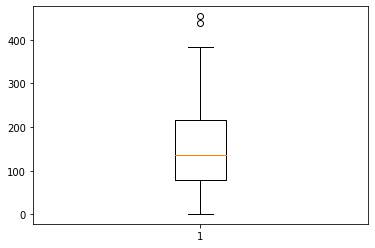

In [10]:
plt.boxplot(turkcell_data.TextSize) # plot TextSize column
plt.show()

## <a class="anchor" id="3.1.">3.1. Visualize the Dataset</a>

Text(0.5, 1.0, 'Dataset labels distribuition')

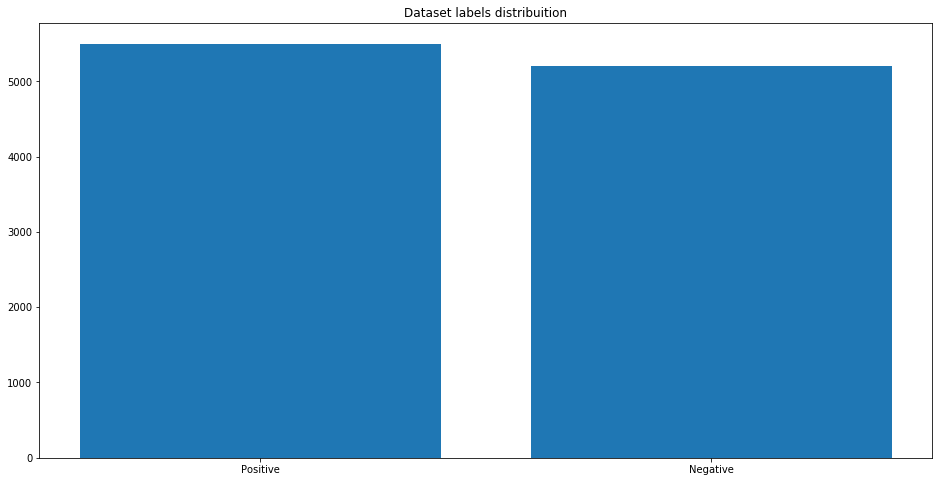

In [11]:
target_tdS = Counter(turkcell_data.Sentiment)

plt.figure(figsize=(16,8))
plt.bar(target_tdS.keys(), target_tdS.values())
plt.title("Dataset labels distribuition")

## <a class="anchor" id="3.2.">3.2. Emoticons Used in the Dataset</a>

In [12]:
tweets_text = turkcell_data.Tweets.str.cat()
emoticons = set(re.findall(r" ([xX:;][-']?.) ", tweets_text))
emoticons_count = []
for emot in emoticons:
    emoticons_count.append((tweets_text.count(emot), emot))
sorted(emoticons_count, reverse=True)

[(883, ':/'),
 (161, ': '),
 (159, ':)'),
 (49, ':('),
 (32, ':D'),
 (11, 'X2'),
 (9, 'x2'),
 (9, ':d'),
 (5, 'x4'),
 (4, ';)'),
 (2, ":')")]

In [13]:
happy_emot = r" ([xX;:]-?[dD)]|:-?[\)]|[;:]|[:')][pP]) "
sad_emot = r" (:'?[/|\(]) "
print("Happy emoticons:", set(re.findall(happy_emot, tweets_text)))
print("Sad emoticons:", set(re.findall(sad_emot, tweets_text)))

Happy emoticons: {':d', ':', ':)', ':D', ';', ';)'}
Sad emoticons: {':(', ':/'}


# <a class="anchor" id="4.">4. Normalization & Preprocessing & Stemming</a>

## <a class="anchor" id="4.1.">4.1. Text Normalization</a>

In [14]:
#Tokenization of text
tokenizer = ToktokTokenizer()

#Setting Turkish stopwords
stopword_list = open('turkce-stop-words', 'r').read().split()

In [15]:
def most_used_words(text):
    tokens = tokenizer.tokenize(text)
    frequency_dist = nltk.FreqDist(tokens)
    print("There is %d different words" % len(set(tokens)))
    return sorted(frequency_dist, key=frequency_dist.__getitem__, reverse=True)

In [16]:
sorted(most_used_words(turkcell_data.Tweets.str.cat())[:150])

There is 49132 different words


['!',
 '"',
 '#Turkcell',
 '#turkcell',
 "'",
 '(',
 ')',
 ',',
 '.',
 '..',
 '...',
 '1',
 '10',
 '2',
 '20',
 '3',
 '4',
 '5',
 ':',
 '?',
 '@TurkTelekom',
 '@Turkcell',
 '@TurkcellHizmet',
 '@VodafoneTR',
 'Allah',
 'Bir',
 'Bu',
 'GB',
 'Superonline',
 'TL',
 'Telekom',
 'Turkcell',
 'Türk',
 'Vodafone',
 'a',
 'ama',
 'artık',
 'ay',
 'aynı',
 'bana',
 'başka',
 'ben',
 'beni',
 'benim',
 'bi',
 'bile',
 'bir',
 'biz',
 'bu',
 'bunu',
 'böyle',
 'cevap',
 'da',
 'daha',
 'dan',
 'de',
 'den',
 'destek',
 'devam',
 'değil',
 'diye',
 'e',
 'en',
 'evde',
 'fatura',
 'fazla',
 'gb',
 'geri',
 'geçtim',
 'gibi',
 'gün',
 'gündür',
 'güzel',
 'hala',
 'hat',
 'hediye',
 'hem',
 'her',
 'hizmet',
 'hiç',
 'i',
 'ile',
 'ilk',
 'in',
 'internet',
 'interneti',
 'iptal',
 'iyi',
 'için',
 'iş',
 'kadar',
 'ki',
 'kullanıyorum',
 'lira',
 'mesaj',
 'mi',
 'mu',
 'müşteri',
 'mı',
 'nasıl',
 'ne',
 'neden',
 'o',
 'olan',
 'olarak',
 'oldu',
 'olsun',
 'olur',
 'operatör',
 'paket',
 'para

In [17]:
mw = most_used_words(turkcell_data.Tweets.str.cat())
most_words = []
for w in mw:
    if len(most_words) == 1000:
        break
    if w in stopword_list:
        continue
    else:
        most_words.append(w)

There is 49132 different words


In [18]:
sorted(most_words[:150])

['!',
 '"',
 '#Turkcell',
 '#turkcell',
 "'",
 '(',
 ')',
 ',',
 '.',
 '..',
 '...',
 '1',
 '10',
 '15',
 '2',
 '20',
 '24',
 '3',
 '30',
 '4',
 '5',
 '6',
 ':',
 '?',
 '@SuperYardim',
 '@TurkTelekom',
 '@Turkcell',
 '@TurkcellHizmet',
 '@VodafoneDestek',
 '@VodafoneTR',
 '@turkcell',
 'Allah',
 'Ama',
 'Ben',
 'Bir',
 'Bu',
 'GB',
 'Ne',
 'Superonline',
 'TL',
 'TURKCELL',
 'Telekom',
 'Turkcell',
 'Türk',
 'Vodafone',
 'a',
 'an',
 'ay',
 'aydır',
 'aynı',
 'başka',
 'be',
 'bedeli',
 'bende',
 'bi',
 'bugün',
 'büyük',
 'cevap',
 'dakika',
 'den',
 'destek',
 'devam',
 'değil',
 'dk',
 'dönüş',
 'ev',
 'evde',
 'fatura',
 'fazla',
 'gb',
 'geldi',
 'gelen',
 'geri',
 'gerçekten',
 'geçiş',
 'geçtim',
 'gün',
 'gündür',
 'günlerde',
 'güzel',
 'hafta',
 'hat',
 'hattı',
 'hattım',
 'hattımı',
 'hayat',
 'hayata',
 'hediye',
 'hemen',
 'hizmet',
 'hizmetleri',
 'hız',
 'ilk',
 'in',
 'internet',
 'internete',
 'interneti',
 'iptal',
 'istiyorum',
 'iyi',
 'iş',
 'kere',
 'kullanıyorum

## <a class="anchor" id="4.2.">4.2. Preprocessing</a>

In [19]:
# Remove the html
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Remove the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Remove the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

turkcell_data['Tweets'] = turkcell_data['Tweets'].apply(denoise_text)

In [20]:
def stemWord(text):
    return text.lower()

# Remove usernames
def removeUsernames(text):
    return re.sub('@[^\s]+', '', text)

# Remove hashtags
def removeHashtags(text):
    return re.sub(r'#[^\s]+', ' ', text)

# Remove punctuation
def removePunctuation(text):
    return re.sub(r'[^\w\s]', ' ', text)

# Remove single character
def singleCharacterRemove(text):
    return re.sub(r'(?:^| )\w(?:$| )', ' ', text)
                  
# Remove emoticon
def stripEmoji(text):
    emoji = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
    return emoji.sub(r'', text)

def splitIntoStem(text):
    text = stemWord(text)
    text = removeUsernames(text)
    text = removeHashtags(text)
    text = removePunctuation(text)
    text = singleCharacterRemove(text)
    text = stripEmoji(text)
    return text


turkcell_data['Tweets'] = turkcell_data['Tweets'].apply(splitIntoStem)

In [21]:
# Remove pic.twitter
def picTwitter(text):
    pic_pat = r'pic.[^ ]+'
    text = re.sub(pic_pat, '', text)
    return text
    
turkcell_data['Tweets'] = turkcell_data['Tweets'].apply(picTwitter)

# Remove pic.twitter2
def picTwitter2(text):
    pic_pat2 = r'com.[^ ]+'
    text = re.sub(pic_pat2, '', text)
    return text

turkcell_data['Tweets'] = turkcell_data['Tweets'].apply(picTwitter2)

In [22]:
'''# Remove turkcell
def operator(text):
    t = r'turkcell'
    v = r'vodafone'
    tt = r'turktelekom'
    so = r'superonline'
    sy = r'superyardim'
    text = re.sub(t, '', text)
    text = re.sub(v, '', text)
    text = re.sub(tt, '', text)
    return text


turkcell_data['Tweets'] = turkcell_data['Tweets'].apply(operator)'''

"# Remove turkcell\ndef operator(text):\n    t = r'turkcell'\n    v = r'vodafone'\n    tt = r'turktelekom'\n    so = r'superonline'\n    sy = r'superyardim'\n    text = re.sub(t, '', text)\n    text = re.sub(v, '', text)\n    text = re.sub(tt, '', text)\n    return text\n\n\nturkcell_data['Tweets'] = turkcell_data['Tweets'].apply(operator)"

In [23]:
turkcell_data['Tweets']

0                                                                                                                                                                                                                             turkcell in sahibi kim  atarı kime acaba bu arkadaşın  
1                                                                                                                                        benim var dışardan gelene 50 lira yaptığınız tarife 17 yıllık müşteriniz olan bana 105 lira  değiştireceğim az kaldo   hangisi daha uygunsa 
2                                                                                                                                                                                                                                       acaba turkcell bana da bi kalp gönderir mi   
3                    turkcell ceo dediki  cezanın ayarını cezayı yazan arkadaşların kendi vicdanlarına bırakıyorum  bizdeki saat 15 dakikalık yoğunluk  kesinti değil 

In [24]:
turkcell_data.head()

,Tweets,Sentiment,TextSize
0,turkcell in sahibi kim atarı kime acaba bu arkadaşın,Positive,55
1,benim var dışardan gelene 50 lira yaptığınız tarife 17 yıllık müşteriniz olan bana 105 lira değiştireceğim az kaldo hangisi daha uygunsa,Positive,158
2,acaba turkcell bana da bi kalp gönderir mi,Positive,62
3,turkcell ceo dediki cezanın ayarını cezayı yazan arkadaşların kendi vicdanlarına bırakıyorum bizdeki saat 15 dakikalık yoğunluk kesinti değil yoğunluk karşısında ise 27 saat kesinti herkes elini vicdanına koysun cezanın bedelini de vicdanına sorsun,Positive,258
4,15 günlük meceramda anladımkı ucuz etin yahnisi olmazmış keşke bizi hakkıyla öpen den ayrılmasaydım nasipse yarın saat 14 26 suları itibari ile bıraktığımız yerden devam edicez iyiki varsın,Positive,225


In [25]:
turkcell_data['TextSizeBeforeRemoveStopWords'] = [len(t) for t in turkcell_data.Tweets]
turkcell_data.head()

,Tweets,Sentiment,TextSize,TextSizeBeforeRemoveStopWords
0,turkcell in sahibi kim atarı kime acaba bu arkadaşın,Positive,55,55
1,benim var dışardan gelene 50 lira yaptığınız tarife 17 yıllık müşteriniz olan bana 105 lira değiştireceğim az kaldo hangisi daha uygunsa,Positive,158,140
2,acaba turkcell bana da bi kalp gönderir mi,Positive,62,47
3,turkcell ceo dediki cezanın ayarını cezayı yazan arkadaşların kendi vicdanlarına bırakıyorum bizdeki saat 15 dakikalık yoğunluk kesinti değil yoğunluk karşısında ise 27 saat kesinti herkes elini vicdanına koysun cezanın bedelini de vicdanına sorsun,Positive,258,256
4,15 günlük meceramda anladımkı ucuz etin yahnisi olmazmış keşke bizi hakkıyla öpen den ayrılmasaydım nasipse yarın saat 14 26 suları itibari ile bıraktığımız yerden devam edicez iyiki varsın,Positive,225,195


### Removing StopWords

In [26]:
# Set Stopwords to Turkish
stop = set(stopword_list)

def remove_stopwords(text, is_lower_case = True):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

turkcell_data['Tweets'] = turkcell_data['Tweets'].apply(remove_stopwords)

In [27]:
turkcell_data['TextSizeAfterRemoveStopWords'] = [len(t) for t in turkcell_data.Tweets]
turkcell_data.head()

,Tweets,Sentiment,TextSize,TextSizeBeforeRemoveStopWords,TextSizeAfterRemoveStopWords
0,turkcell in sahibi atarı arkadaşın,Positive,55,55,34
1,dışardan gelene 50 lira yaptığınız tarife 17 yıllık müşteriniz 105 lira değiştireceğim kaldo uygunsa,Positive,158,140,100
2,turkcell bi kalp gönderir,Positive,62,47,25
3,turkcell ceo dediki cezanın ayarını cezayı yazan arkadaşların vicdanlarına bırakıyorum bizdeki saat 15 dakikalık yoğunluk kesinti değil yoğunluk karşısında 27 saat kesinti elini vicdanına koysun cezanın bedelini vicdanına sorsun,Positive,258,256,228
4,15 günlük meceramda anladımkı ucuz etin yahnisi olmazmış keşke hakkıyla öpen den ayrılmasaydım nasipse yarın saat 14 26 suları itibari bıraktığımız yerden devam edicez iyiki varsın,Positive,225,195,180


## <a class="anchor" id="4.3.">4.3. Text Stemming</a>

In [28]:
turkStem = TurkishStemmer()

# Stemming
def simple_stemmer(text):
    ss = TurkishStemmer()
    text = ' '.join([ss.stemWord(word) for word in text.split()])
    return text

turkcell_data['Tweets'] = turkcell_data['Tweets'].apply(simple_stemmer)

In [29]:
turkcell_data['TextSizeStemming'] = [len(t) for t in turkcell_data.Tweets]
turkcell_data.head()

,Tweets,Sentiment,TextSize,TextSizeBeforeRemoveStopWords,TextSizeAfterRemoveStopWords,TextSizeStemming
0,turkcell in sahip atar arkadaş,Positive,55,55,34,30
1,dışar gele 50 lira yaptık tarif 17 yıllık müşter 105 lira değiştirecek kaldo uygu,Positive,158,140,100,81
2,turkcell bi kalp gönderir,Positive,62,47,25,25
3,turkcell ceo dedik ceza ayar ceza yaza arkadaş vicdan bırakıyor biz saat 15 dakikalık yoğunluk kes değil yoğunluk karşı 27 saat kes el vicdan koy ceza bedel vicdan sor,Positive,258,256,228,167
4,15 günlük mecera anladımkı uç et yahnis olmaz keşke hakkı öpe den ayrılmas nasip yar saat 14 26 su itibar bıraktık yer deva edicez iyik var,Positive,225,195,180,139


                                                            turkcell_data[0] Text Size

| # | Original | Preprocess | RemoveStopWords | Stemming |
|------|------|------|------|
|TextSize| 55 | 55 | 34 | 30 |

# <a class="anchor" id="5.">5. Feature Extraction</a>

### Labeling the sentiment text

In [30]:
turkcell_data.Sentiment.replace(['Negative', 'Positive'], [0, 1], inplace = True)
turkcell_data.head()

,Tweets,Sentiment,TextSize,TextSizeBeforeRemoveStopWords,TextSizeAfterRemoveStopWords,TextSizeStemming
0,turkcell in sahip atar arkadaş,1,55,55,34,30
1,dışar gele 50 lira yaptık tarif 17 yıllık müşter 105 lira değiştirecek kaldo uygu,1,158,140,100,81
2,turkcell bi kalp gönderir,1,62,47,25,25
3,turkcell ceo dedik ceza ayar ceza yaza arkadaş vicdan bırakıyor biz saat 15 dakikalık yoğunluk kes değil yoğunluk karşı 27 saat kes el vicdan koy ceza bedel vicdan sor,1,258,256,228,167
4,15 günlük mecera anladımkı uç et yahnis olmaz keşke hakkı öpe den ayrılmas nasip yar saat 14 26 su itibar bıraktık yer deva edicez iyik var,1,225,195,180,139


## <a class="anchor" id="5.1.">5.1. Split Dataset Intro Train and Test</a>

In [31]:
sent = turkcell_data['Sentiment']
tw = turkcell_data['Tweets']

# Split the data / Ratio is 80:20
X_train, X_test, y_train, y_test = train_test_split(tw, sent, test_size = 0.20, random_state= 1)


# X_train is the tweets of training data, 
# X_test is the testing tweets which we have to predict 
# y_train is the sentiments of tweets in the traing data
# y_test is the sentiments of the tweets which we will use to measure the accuracy of the model

## <a class="anchor" id="5.2.">5.2. Bag of Words</a>

In [32]:
# CountVectorizer for Bag of Words
cv = CountVectorizer(min_df = 0, max_df = 1, binary = False, ngram_range = (1, 3))

# Transformed train tweets
cv_train_tweets = cv.fit_transform(X_train)

# Transformed test tweets
cv_test_tweets = cv.transform(X_test)

print('BoW_CV_Train:',cv_train_tweets.shape)
print('BoW_CV_Test:',cv_test_tweets.shape)

BoW_CV_Train: (8560, 170489)
BoW_CV_Test: (2140, 170489)


In [33]:
s = cv_train_tweets[1]
print(s)

  (0, 128523)	1
  (0, 110028)	1
  (0, 48828)	1
  (0, 80389)	1
  (0, 81674)	1
  (0, 15311)	1
  (0, 128524)	1
  (0, 123281)	1
  (0, 110029)	1
  (0, 5945)	1
  (0, 78212)	1
  (0, 48829)	1
  (0, 80390)	1
  (0, 81675)	1
  (0, 98761)	1


In [34]:
ss = cv_test_tweets[1]
print(ss)

  (0, 56274)	1
  (0, 70185)	1
  (0, 126527)	1
  (0, 126528)	1


## <a class="anchor" id="5.3.">5.3. Term FrequencyxInverse Document Frequency / TFxIDF</a>

In [35]:
# TfidfVectorizer
tv = TfidfVectorizer(min_df = 0, max_df = 1, use_idf = True, ngram_range = (1, 3))

# Transformed train tweets
tv_train_tweets = tv.fit_transform(X_train)

# Transformed test tweets
tv_test_tweets = tv.transform(X_test)

print('Tfidf_Train:',tv_train_tweets.shape)
print('Tfidf_Test:',tv_test_tweets.shape)

Tfidf_Train: (8560, 170489)
Tfidf_Test: (2140, 170489)


In [36]:
s = tv_train_tweets[1]
print(s)

  (0, 98761)	0.2581988897471611
  (0, 81675)	0.2581988897471611
  (0, 80390)	0.2581988897471611
  (0, 48829)	0.2581988897471611
  (0, 78212)	0.2581988897471611
  (0, 5945)	0.2581988897471611
  (0, 110029)	0.2581988897471611
  (0, 123281)	0.2581988897471611
  (0, 128524)	0.2581988897471611
  (0, 15311)	0.2581988897471611
  (0, 81674)	0.2581988897471611
  (0, 80389)	0.2581988897471611
  (0, 48828)	0.2581988897471611
  (0, 110028)	0.2581988897471611
  (0, 128523)	0.2581988897471611


In [37]:
ss = tv_test_tweets[1]
print(ss)

  (0, 126528)	0.5
  (0, 126527)	0.5
  (0, 70185)	0.5
  (0, 56274)	0.5


# <a class="anchor" id="6.">6. Modelling the Dataset</a>

## <a class="anchor" id="6.1.">6.1. Logistic Regression</a>

In [38]:
# Training the Model
lr = LogisticRegression(penalty = 'l2', max_iter = 500, C = 1.1, random_state = 42)

# Fitting the model for Bag of Words
lr_bow = lr.fit(cv_train_tweets, y_train)
print(lr_bow)

# Fitting the model for TFIDF features
lr_tfidf = lr.fit(tv_train_tweets, y_train)
print(lr_tfidf)

LogisticRegression(C=1.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
LogisticRegression(C=1.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [39]:
# Predicting the model for Bag of Words
lr_bow_predict = lr.predict(cv_test_tweets)
print(lr_bow_predict)

# Predicting the model for TFIDF features
lr_tfidf_predict = lr.predict(tv_test_tweets)
print(lr_tfidf_predict)

[1 1 0 ... 1 1 1]
[1 1 0 ... 1 1 1]


In [40]:
# Accuracy score for Bag of Words
lr_bow_score = accuracy_score(y_test, lr_bow_predict)
print("LR BoW Score :",lr_bow_score)

# Accuracy score for TFIDF features
lr_tfidf_score = accuracy_score(y_test, lr_tfidf_predict)
print("LR TFIDF Score :",lr_tfidf_score)

LR BoW Score : 0.6327102803738318
LR TFIDF Score : 0.6135514018691589


In [41]:
# Classification report for Bag of Words
lr_bow_report = classification_report(y_test, lr_bow_predict, target_names = ['Positive','Negative'])
print(lr_bow_report)

# Classification report for TFIDF features
lr_tfidf_report = classification_report(y_test, lr_tfidf_predict, target_names = ['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.71      0.42      0.53      1053
    Negative       0.60      0.84      0.70      1087

    accuracy                           0.63      2140
   macro avg       0.66      0.63      0.61      2140
weighted avg       0.66      0.63      0.62      2140

              precision    recall  f1-score   support

    Positive       0.71      0.36      0.48      1053
    Negative       0.58      0.85      0.69      1087

    accuracy                           0.61      2140
   macro avg       0.64      0.61      0.59      2140
weighted avg       0.64      0.61      0.59      2140



In [42]:
# Confusion matrix for Bag of Words
cm_bow = confusion_matrix(y_test, lr_bow_predict, labels = [1,0])
print(cm_bow)

# Confusion matrix for TFIDF features
cm_tfidf = confusion_matrix(y_test, lr_tfidf_predict, labels = [1,0])
print(cm_tfidf)

[[908 179]
 [607 446]]
[[929 158]
 [669 384]]


## <a class="anchor" id="6.2.">6.2. SGDClassifier</a>

In [43]:
# Training the Linear SVM
svm = SGDClassifier(loss='hinge', max_iter=500, random_state=42)

# Fitting the SVM for Bag of Words
svm_bow = svm.fit(cv_train_tweets, y_train)
print(svm_bow)

# Fitting the SVM for TFIDF features
svm_tfidf = svm.fit(tv_train_tweets, y_train)
print(svm_tfidf)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=500, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=500, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


In [44]:
# Predicting the model for Bag of Words
svm_bow_predict = svm.predict(cv_test_tweets)
print(svm_bow_predict)

# Predicting the model for TFIDF features
svm_tfidf_predict = svm.predict(tv_test_tweets)
print(svm_tfidf_predict)

[1 1 0 ... 1 1 1]
[1 1 0 ... 1 1 1]


In [45]:
# Accuracy score for Bag of Words
svm_bow_score = accuracy_score(y_test, svm_bow_predict)
print("SVM BoW Score :",svm_bow_score)

# Accuracy score for TFIDF features
svm_tfidf_score = accuracy_score(y_test, svm_tfidf_predict)
print("SVM TFIDF Score:",svm_tfidf_score)

SVM BoW Score : 0.6434579439252337
SVM TFIDF Score: 0.6350467289719626


In [46]:
# Classification report for Bag of Words 
svm_bow_report = classification_report(y_test, svm_bow_predict, target_names = ['Positive','Negative'])
print(svm_bow_report)

# Classification report for TFIDF features
svm_tfidf_report = classification_report(y_test, svm_tfidf_predict, target_names = ['Positive','Negative'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.68      0.52      0.59      1053
    Negative       0.62      0.76      0.69      1087

    accuracy                           0.64      2140
   macro avg       0.65      0.64      0.64      2140
weighted avg       0.65      0.64      0.64      2140

              precision    recall  f1-score   support

    Positive       0.68      0.48      0.57      1053
    Negative       0.61      0.78      0.68      1087

    accuracy                           0.64      2140
   macro avg       0.65      0.63      0.63      2140
weighted avg       0.65      0.64      0.63      2140



In [47]:
# Confusion matrix for Bag of Words
cm_bow = confusion_matrix(y_test, svm_bow_predict, labels = [1,0])
print(cm_bow)

# Confusion matrix for TFIDF features
cm_tfidf = confusion_matrix(y_test, svm_tfidf_predict, labels = [1,0])
print(cm_tfidf)

[[830 257]
 [506 547]]
[[849 238]
 [543 510]]


## <a class="anchor" id="6.3.">6.3. Naive Bayes</a>

In [48]:
# Training the model
mnb = MultinomialNB()

# Fitting the NB for Bag of Words
mnb_bow = mnb.fit(cv_train_tweets, y_train)
print(mnb_bow)

# Fitting the NB for TFIDF features
mnb_tfidf = mnb.fit(tv_train_tweets, y_train)
print(mnb_tfidf)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


In [49]:
# Predicting the model for Bag of Words
mnb_bow_predict = mnb.predict(cv_test_tweets)
print(mnb_bow_predict)

# Predicting the model for TFIDF features
mnb_tfidf_predict = mnb.predict(tv_test_tweets)
print(mnb_tfidf_predict)

[1 1 0 ... 1 1 1]
[1 1 0 ... 1 1 1]


In [50]:
# Accuracy score for Bag of Words
mnb_bow_score = accuracy_score(y_test, mnb_bow_predict)
print("MNB BoW Score :",mnb_bow_score)

# Accuracy score for TFIDF features
mnb_tfidf_score = accuracy_score(y_test, mnb_tfidf_predict)
print("MNB TFIDF Score :",mnb_tfidf_score)

MNB BoW Score : 0.6364485981308411
MNB TFIDF Score : 0.6322429906542056


In [51]:
# Classification report for Bag of Words
mnb_bow_report = classification_report(y_test, mnb_bow_predict, target_names = ['Positive','Negative'])
print(mnb_bow_report)

# Classification report for TFIDF features
mnb_tfidf_report = classification_report(y_test, mnb_tfidf_predict, target_names = ['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.68      0.50      0.57      1053
    Negative       0.61      0.77      0.68      1087

    accuracy                           0.64      2140
   macro avg       0.65      0.63      0.63      2140
weighted avg       0.64      0.64      0.63      2140

              precision    recall  f1-score   support

    Positive       0.68      0.48      0.56      1053
    Negative       0.61      0.78      0.68      1087

    accuracy                           0.63      2140
   macro avg       0.64      0.63      0.62      2140
weighted avg       0.64      0.63      0.62      2140



In [52]:
# Confusion matrix for Bag of Words
cm_bow = confusion_matrix(y_test, mnb_bow_predict, labels = [1,0])
print(cm_bow)

# Confusion matrix for TFIDF features
cm_tfidf = confusion_matrix(y_test, mnb_tfidf_predict, labels = [1,0])
print(cm_tfidf)

[[836 251]
 [527 526]]
[[851 236]
 [551 502]]
